In [55]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [41]:
train = pd.read_csv("Train_UWu5bXk.csv")

test = pd.read_csv("Test_u94Q5KV.csv")

In [42]:
train["Source"] = "train"
test["Source"] = "test"
data = pd.concat([train,test],ignore_index = True)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 14203
Data columns (total 13 columns):
Item_Fat_Content             14204 non-null object
Item_Identifier              14204 non-null object
Item_MRP                     14204 non-null float64
Item_Outlet_Sales            8523 non-null float64
Item_Type                    14204 non-null object
Item_Visibility              14204 non-null float64
Item_Weight                  11765 non-null float64
Outlet_Establishment_Year    14204 non-null int64
Outlet_Identifier            14204 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Size                  10188 non-null object
Outlet_Type                  14204 non-null object
Source                       14204 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 1.5+ MB


In [32]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [6]:
#frequencies of different categories in the features
cat_col = [x for x in data.columns if data[x].dtype=='object']

#exclude Id cols and source
cat_col = [x for x in cat_col if x not in ['Item_Identifier','Outlet_Identifier','Source']]

for i in cat_col:
    print('\nFrequency of Categories for varible %s'%i)
    print(data[i].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

# data cleaning

In [7]:
data.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
Source                          0
dtype: int64

In [44]:
#replace missing weight values
item_avg_weight = data.pivot_table(values="Item_Weight", index="Item_Identifier")

miss = data["Item_Weight"].isnull()

data.loc[miss,"Item_Weight"] = data.loc[miss,"Item_Identifier"].apply(lambda x: item_avg_weight[x])

In [45]:
#replace missing outlet size with mode for that particular type of outlet
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print 'Mode for each Outlet_Type:'
print outlet_size_mode

miss = data['Outlet_Size'].isnull() 

data.loc[miss,'Outlet_Size'] = data.loc[miss,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

Mode for each Outlet_Type:
Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object


In [46]:
#item visibililty had a few values 0. This is replaced by mean for that particular item

vis_avg = data.pivot_table(values='Item_Visibility',index="Item_Identifier")

miss = data['Item_Visibility']==0

data.loc[miss,'Item_Visibility'] = data.loc[miss,"Item_Identifier"].apply(lambda x: vis_avg[x])

In [47]:
#Determine another variable with means ratio

data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/vis_avg[x['Item_Identifier']], axis=1)
print data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [48]:
#convert years to a relative value, with reference 2013 as given in the problem statement

data["Outlet_Establishment_Year"] = data["Outlet_Establishment_Year"].apply(lambda x: 2013-x)

In [49]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [50]:
#Change categories of low fat:

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})

# replace non-consumable product's fat content value
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [51]:
data["Outlet"] = data["Outlet_Identifier"]
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined',"Outlet"])

data.dtypes

Item_Identifier                       object
Item_MRP                             float64
Item_Outlet_Sales                    float64
Item_Type                             object
Item_Visibility                      float64
Item_Weight                          float64
Outlet_Establishment_Year              int64
Outlet_Identifier                     object
Source                                object
Item_Visibility_MeanRatio            float64
Item_Fat_Content_Low Fat             float64
Item_Fat_Content_Non-Edible          float64
Item_Fat_Content_Regular             float64
Outlet_Location_Type_Tier 1          float64
Outlet_Location_Type_Tier 2          float64
Outlet_Location_Type_Tier 3          float64
Outlet_Size_High                     float64
Outlet_Size_Medium                   float64
Outlet_Size_Small                    float64
Outlet_Type_Grocery Store            float64
Outlet_Type_Supermarket Type1        float64
Outlet_Type_Supermarket Type2        float64
Outlet_Typ

In [62]:
#Divide into test and train
train = data.loc[data['Source']=="train"]
test = data.loc[data['Source']=="test"]

#Drop unnecessary columns
test.drop(['Item_Outlet_Sales','Source',"Item_Type"],axis=1,inplace=True)
train.drop(['Source',"Item_Type"],axis=1,inplace=True)

#save modified files
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

In [57]:
#function for making model, performing cross-validation and storing the result

target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation, metrics

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print "\nModel Report"
    print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))
    print "CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

# linear regression


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 43.79 | Min - 1020 | Max - 1162


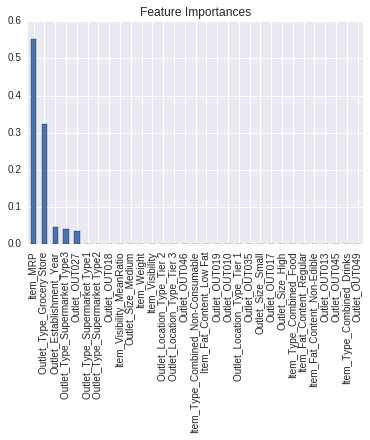

In [64]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances') 